# Data Analysis of Call Records

# Importing important libraries

In [677]:
import pandas as pd
import numpy as np
import os
from fancyimpute import KNN
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import mpld3
mpld3.enable_notebook()
%matplotlib inline

# Reading call records file

In [589]:
os.chdir("C:/Users/mudmoham/Documents/pr/Call Records")
calls_df=pd.read_excel("Call Records.xlsx",sheetname="Call Records",na_values=["NULL",""," "],keep_default_na=False)

let us have a look at the data

In [577]:
calls_df.head()

,call_date,status,user,list_id,length_in_sec,phone number,postal_code,processed,dial_type
0,2017-10-03 09:42:00,NC,jyotsna,280716,42.0,5609070079,NaN,N,MANUAL
1,2017-10-03 09:44:00,FU,jyotsna,230317,160.0,5812977844,560004,N,MANUAL
2,2017-10-03 09:44:00,FU,prerana,998,77.0,5609216021,NaN,N,MANUAL
3,2017-10-03 09:46:00,FU,anand,998,70.0,6573626240,NaN,N,MANUAL
4,2017-10-03 09:47:00,NC,prerana,998,42.0,6652489606,NaN,N,MANUAL


In [578]:
calls_df.shape

(13144, 9)

It has 13144 call records and 9 columns

Let's have a look at columns

In [579]:
calls_df.columns

Index(['call_date', 'status', 'user', 'list_id', 'length_in_sec',
       'phone number', 'postal_code', 'processed', 'dial_type'],
      dtype='object')

# Missing Value Analysis

In [580]:
missing_val_df=pd.DataFrame(pd.isnull(calls_df).sum()).reset_index()
missing_val_df=missing_val_df.rename(columns={"index":"Columns",0:"Missing Percentage"})
missing_val_df["Missing Percentage"]=missing_val_df["Missing Percentage"]/len(calls_df)*100
missing_val_df=missing_val_df.sort_values("Missing Percentage",ascending=False).reset_index(drop=True)
missing_val_df.head(10)

,Columns,Missing Percentage
0,postal_code,92.977785
1,dial_type,3.050822
2,length_in_sec,0.053256
3,call_date,0.000000
4,status,0.000000
5,user,0.000000
6,list_id,0.000000
7,phone number,0.000000
8,processed,0.000000


### Deleting Postal code variable

In [590]:
calls_df=calls_df.drop(["postal_code"],axis=1)

Postal code has 92 % missing columns which is too high.So it is better to delete the variable.Let's look at dial_type variable

### Imputing Null values with Manual for Dial type column

We know that if dial type is  998 or 999 its manual dialed, others are automated calling list.so replacing with MANUAL can replace some null values and other null values are replaced by AUTO

In [592]:
calls_df.loc[(calls_df["list_id"]==998) | (calls_df["list_id"]==999),"dial_type"]="MANUAL"
calls_df.loc[(calls_df["dial_type"]!="MANUAL"),"dial_type"]="AUTO"

In [594]:
calls_df["dial_type"].unique()

array(['MANUAL', 'AUTO'], dtype=object)

We can see that null values are replaced by MANUAL and AUTO

### Imputing null values for length_in_sec column through KNN

In [593]:
calls_temp=pd.DataFrame(calls_df["length_in_sec"])
calls_temp=pd.DataFrame(KNN(k=3).complete(calls_temp),columns=calls_temp.columns)
calls_df=calls_df.drop(["length_in_sec"],axis=1)
calls_df["length_in_sec"]=calls_temp["length_in_sec"]
calls_df.head()

Imputing row 1/13144 with 0 missing, elapsed time: 18.811
Imputing row 101/13144 with 0 missing, elapsed time: 18.812
Imputing row 201/13144 with 0 missing, elapsed time: 18.813
Imputing row 301/13144 with 0 missing, elapsed time: 18.813
Imputing row 401/13144 with 0 missing, elapsed time: 18.815
Imputing row 501/13144 with 0 missing, elapsed time: 18.816
Imputing row 601/13144 with 0 missing, elapsed time: 18.816
Imputing row 701/13144 with 0 missing, elapsed time: 18.817
Imputing row 801/13144 with 0 missing, elapsed time: 18.819
Imputing row 901/13144 with 0 missing, elapsed time: 18.819
Imputing row 1001/13144 with 0 missing, elapsed time: 18.820
Imputing row 1101/13144 with 0 missing, elapsed time: 18.820
Imputing row 1201/13144 with 0 missing, elapsed time: 18.820
Imputing row 1301/13144 with 0 missing, elapsed time: 18.821
Imputing row 1401/13144 with 0 missing, elapsed time: 18.821
Imputing row 1501/13144 with 0 missing, elapsed time: 18.822
Imputing row 1601/13144 with 0 missi

,call_date,status,user,list_id,phone number,processed,dial_type,length_in_sec
0,2017-10-03 09:42:00,NC,jyotsna,280716,5609070079,N,MANUAL,42.0
1,2017-10-03 09:44:00,FU,jyotsna,230317,5812977844,N,MANUAL,160.0
2,2017-10-03 09:44:00,FU,prerana,998,5609216021,N,MANUAL,77.0
3,2017-10-03 09:46:00,FU,anand,998,6573626240,N,MANUAL,70.0
4,2017-10-03 09:47:00,NC,prerana,998,6652489606,N,MANUAL,42.0


In [595]:
calls_df["length_in_sec"].isnull().sum()

0

we can see that null values are successfully imputed though KNNImputation

# Feature Engineering

from call_day let us derive week_day_name and day of month october

In [596]:
calls_df["call_day"]=calls_df["call_date"].dt.weekday_name
calls_df["month_day"]=calls_df["call_date"].dt.day

Let us engineer a new variable based on time so that we can concentrate call records based on time of the day

Morning(4-9:59)
Noon(10-15-59)
Evening(16-21:59)
Night(22-3.59)


In [597]:
calls_df["time"]=calls_df["call_date"].dt.hour
calls_df["call_time"]="NULL"

In [598]:
calls_df.loc[(calls_df["time"]>=4) & (calls_df["time"]<10),["call_time"]]="Morning"
calls_df.loc[(calls_df["time"]>=10) & (calls_df["time"]<16),["call_time"]]="Noon"
calls_df.loc[(calls_df["time"]>=16) & (calls_df["time"]<22),["call_time"]]="Evening"
calls_df.loc[(calls_df["time"]>=22) & (calls_df["time"]<4),["call_time"]]="Night"
calls_df["call_time"].unique()

array(['Morning', 'Noon', 'Evening'], dtype=object)

In [599]:
calls_df=calls_df.drop(["call_date","time"],axis=1)

With the help of Feature Engineering,we have successfully created new variables 
1)call_day
2)month_day
3)call_time

### Feature Selection

By observation we can see that list_id and dial_type are highly correlated because if list_id is in 998 or 999 dial type is manual otherwise auto.Hence we can delete list_id variable

Processed column has only one value "N".
So we can drop these two columns from dataframe


In [610]:
calls_df=calls_df.drop(["list_id","processed"],axis=1)

We have successfully cleaned our dataset with help of missing value analysis,feature selection and feature engineering techniques

# Exploratory Data Analysis

In [612]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13144 entries, 0 to 13143
Data columns (total 8 columns):
status           13144 non-null object
user             13144 non-null object
phone number     13144 non-null object
dial_type        13144 non-null object
length_in_sec    13144 non-null float64
call_day         13144 non-null object
month_day        13144 non-null int64
call_time        13144 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 821.6+ KB


### Descriptive statistics of variable

Let's look at the statistics such mean,std,max,min,count of all variables

#### Numerical variable

In [601]:
calls_df.describe()

,list_id,length_in_sec,month_day
count,1.314400e+04,13144.000000,13144.000000
mean,3.186306e+06,84.560408,17.558658
std,1.502380e+07,138.518932,9.020333
min,2.020000e+02,0.000000,3.000000
25%,9.980000e+02,24.000000,10.000000
50%,9.980000e+02,48.000000,18.000000
75%,9.990000e+02,88.250000,26.000000
max,1.111202e+09,5828.000000,31.000000


####  Categorical variable

In [614]:
calls_df.describe(include=["object"])

,status,user,phone number,dial_type,call_day,call_time
count,13144,13144,13144,13144,13144,13144
unique,36,19,4502,2,6,3
top,NC,jyotsna,6365569977,MANUAL,Tuesday,Noon
freq,5811,1700,94,12311,3104,9276


## Univariate visualization

Let us check distribution of numeric variable "lenght in sec".
we can see that this variable is not distrbuted normally

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDD3AE0160>]]


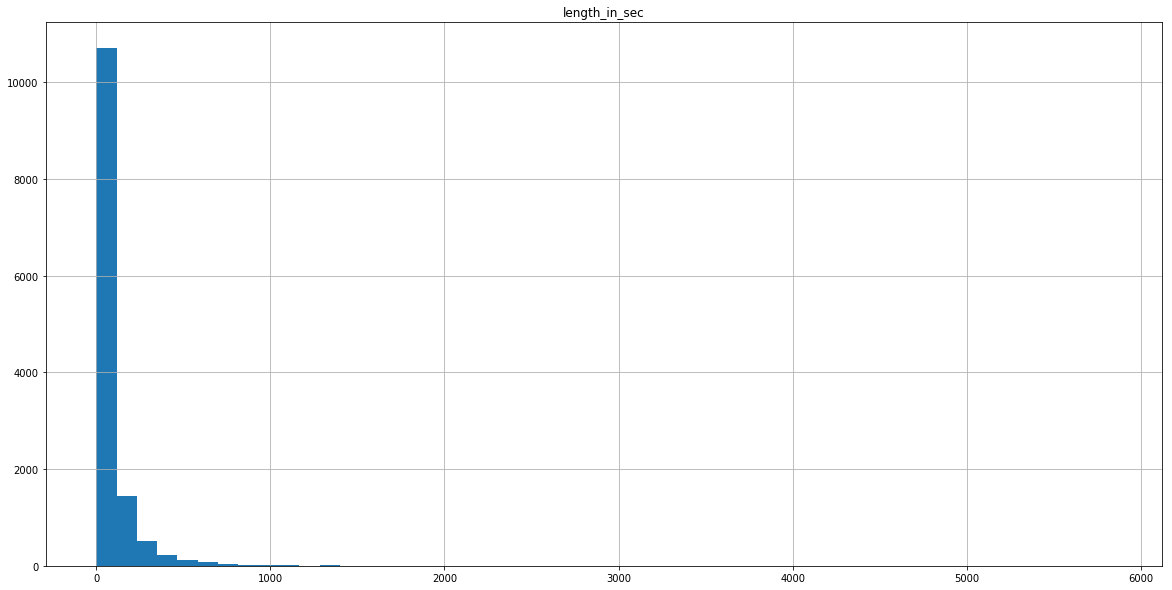

In [639]:
print(calls_df[["length_in_sec"]].hist(bins=50,figsize=(20,10)))

Let us have look at density plot of this varible.we can see that variable is right skewed

### Density plots

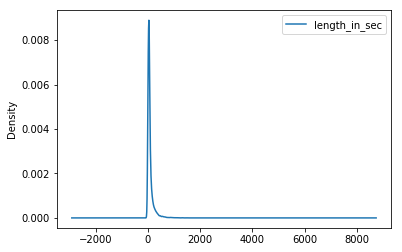

In [640]:
calls_df[["length_in_sec"]].plot(kind="density")

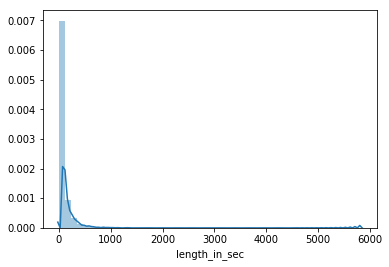

In [641]:
sns.distplot(calls_df["length_in_sec"])

### Box plots and violin plots

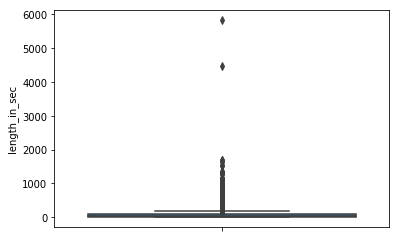

In [642]:
#Outliers
sns.boxplot(calls_df["length_in_sec"],orient='v')

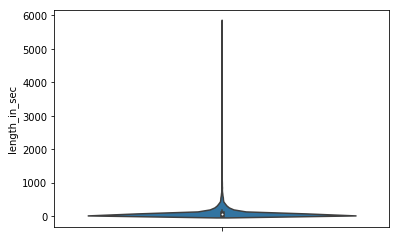

In [643]:
sns.violinplot(calls_df["length_in_sec"],orient='v')

### Categorical Variables Visualization

In [648]:
#Categorical variables
calls_df["dial_type"].value_counts()

MANUAL    12311
AUTO        833
Name: dial_type, dtype: int64

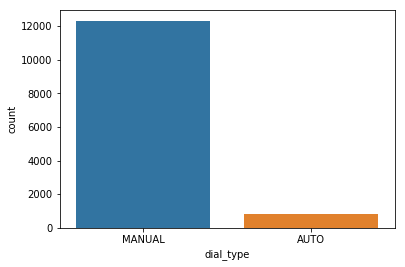

In [647]:
sns.countplot(calls_df["dial_type"])

We can see that there are more number of calls dialled manually from 998 or 999

###  distribution of status and user variable

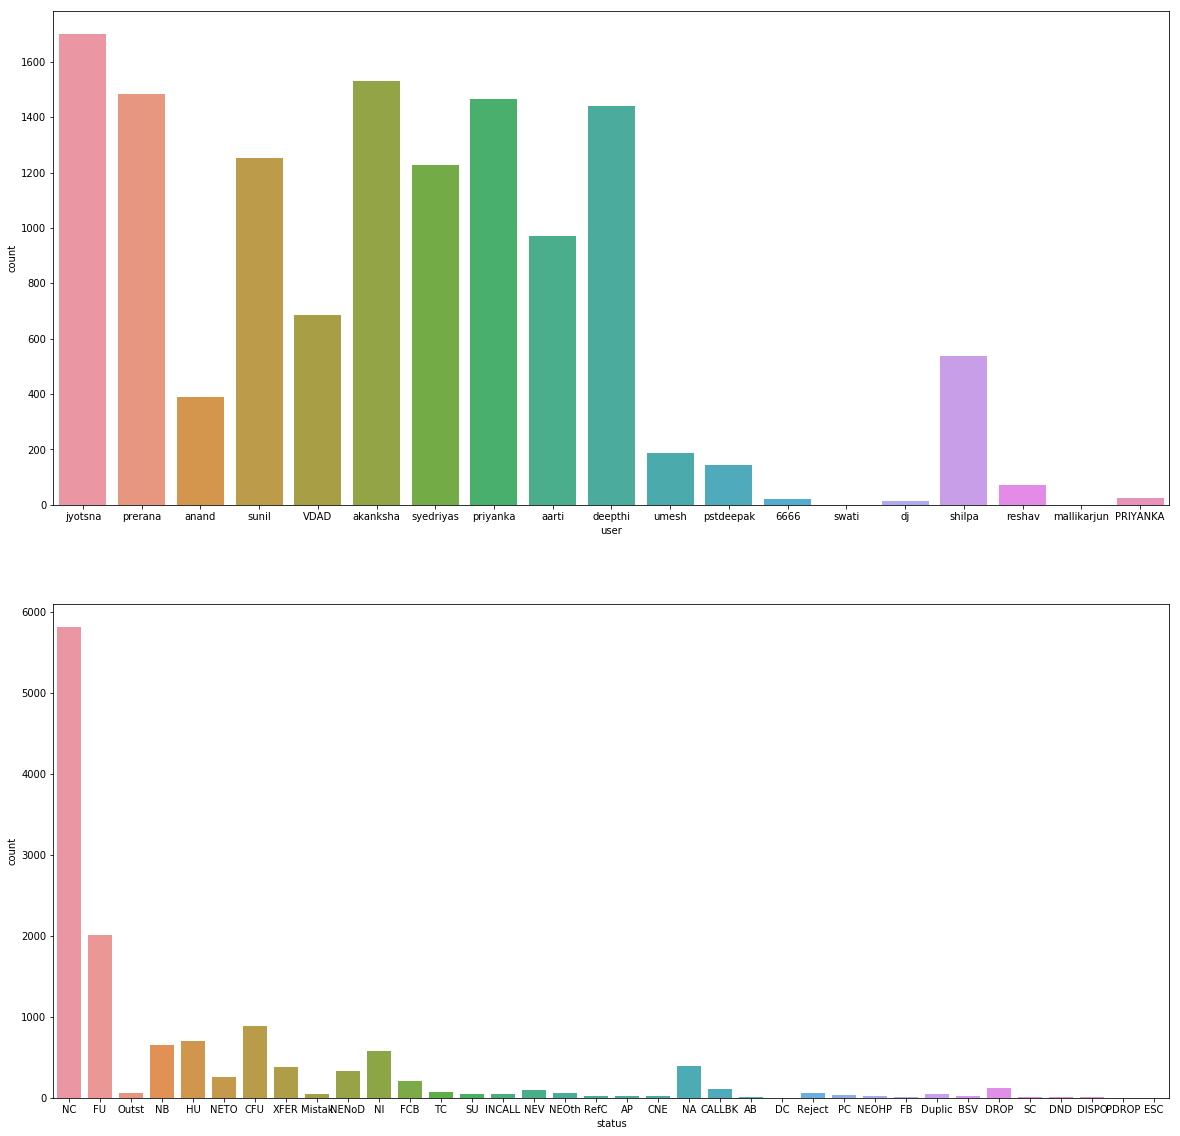

In [649]:
_,ax=plt.subplots(2,1,figsize=(20,20))
sns.countplot(calls_df["user"],ax=ax[0])
sns.countplot(calls_df["status"],ax=ax[1])


Customer care employees who has attended more number of calls are
Jyosthna,prerana,akanksha,priyanka,deepthi user
They contribute almost 50 percent of calls

And most of calls status is NC which means customer is not contactable

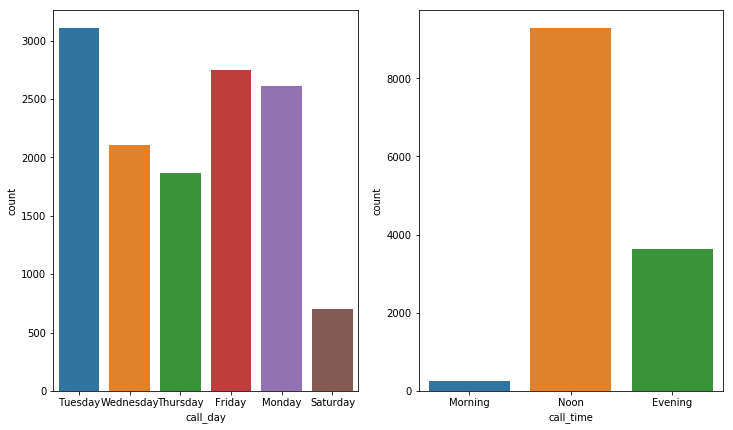

In [650]:
_,ax=plt.subplots(1,2,figsize=(12,7))
sns.countplot(calls_df["call_day"],ax=ax[0])
sns.countplot(calls_df["call_time"],ax=ax[1])

we can see that most of calls are at noon time and evening.
coming to weekdays,
1) Tuesday
2) Friday
3) Monday 
has highest number of calls

### Understanding dispostion file

In [651]:
disposition_df=pd.read_excel("Call Records.xlsx",sheetname="Disposition Definition",na_values=["NULL",""," "],keep_default_na=False).iloc[:,1:]

In [652]:
disposition_df.shape

(36, 4)

In [653]:
disposition_df.columns

Index(['Disposition', 'Call type', 'Customer response', 'Agent analysis'], dtype='object')

In [394]:
disposition_df.head()

,Disposition,Call type,Customer response,Agent analysis
0,AB,NaN,NaN,NaN
1,AP,Appointment Call,NaN,NaN
2,BSV,Background verification call,NaN,NaN
3,CALLBK,NaN,Customer said to call back,NaN
4,CFU,NaN,Customer said to follow up,NaN


### Business Understanding

dispostion_definition has four columns.
Let us categorize the entire dataset into five variables

Important:
These are important calls such as appointment call,feedback call,signup call which are so important to business.
There may be chance that these customers may accept the offer if they are eligible
['AP','ESC','FB','FU','PC','RefC','SC','SU','TC','BSV'] these are converted into Important status

Interested:if customer is interested to call back or follow up or drop off due to system issue.it means customer is interested to listen to offer.So  ['CALLBK','CFU','FCB','INCALL','DROP','PDDROP','XFER'] are converted into "Interested Status"

Not Interested:
['DND','HU','NA','Reject'] If customer is not interested or if he rejects the offers then it means he is not interested

Ignore:
This category has to be ignored from dataset.Mistaken calls,duplicates.These are useless information.
['DC','DISPO','Duplic','Mistak','AB'].These statuse are converted into Ignore statues

Not Eligible:
['CNE','NB','NC','NENoD','NEOHP','NEOth','NETO','NEV','Outst'] these statuses are converted in to Not Eligible statuses as these
customers are not eligible depending on various factors


Business Value:
1)Important
2)Interested

No Business value:
3)Not Eligible
4)Not Interested
5)Ignore


Let us create a new variable based on different statuses
We have created 5 bins 
1)Important
2)Interested
3)Not Eligible
4)Not Interested
5)Ignore

Assigning the different statuses to 5 bins

This helps us classify the dataset based on business understanding

In [656]:
disposition_dict={"Important":['AP','ESC','FB','FU','PC','RefC','SC','SU','TC','BSV'],
                  "Interested":['CALLBK','CFU','FCB','INCALL','DROP','PDDROP','XFER'],
                  "Not Eligilble":['CNE','NB','NC','NENoD','NEOHP','NEOth','NETO','NEV','Outst'],
                  "Not Interested":['DND','HU','NA','Reject'],
                  "Ignore":['DC','DISPO','Duplic','Mistak','AB']}


In [657]:
def getstatus(x):
    for K in disposition_dict.keys():
        if x in disposition_dict[K]:
            return K
calls_df["call_type"]=calls_df["status"].apply(lambda x:getstatus(x))

### distribution  of call type

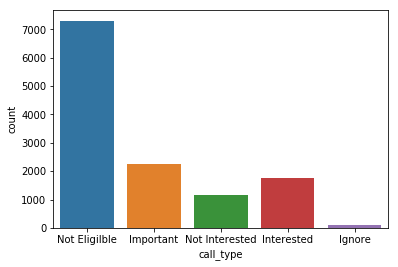

In [658]:
sns.countplot(calls_df["call_type"])

We can see that most number of calls belongs to "Not Eligible" status

### Factor plots 

<IPython.core.display.Javascript object>


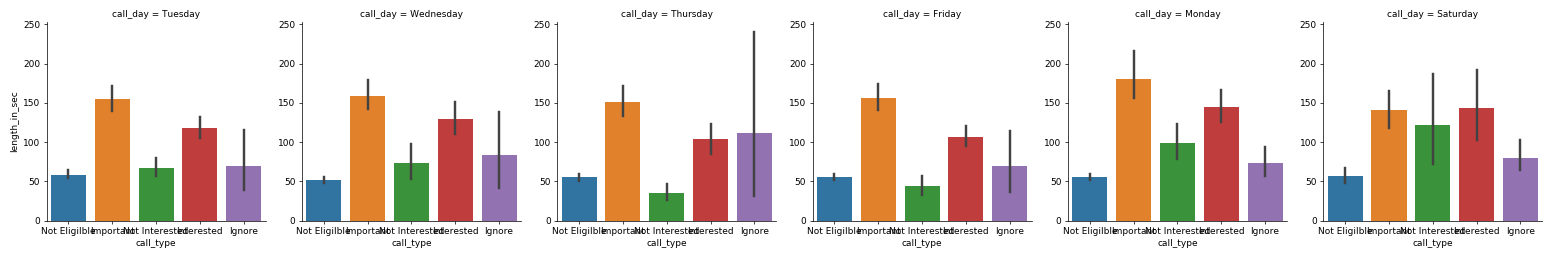

In [449]:
#quantitative-categorical-categorical
sns.factorplot(x='call_type',y='length_in_sec',col='call_day',data=calls_df,kind='bar')

# Top 10 Customers who can made important calls


In [660]:
calls_df.loc[(calls_df["call_type"]=="Important"),"phone number"].value_counts()[0:9]

5419196969    27
5600724140    23
5538515171    21
7652834405    20
5542541114    20
5704663597    19
5881301783    18
5418863566    17
7295734373    17
Name: phone number, dtype: int64

let us look the data of customer with phone number 5419196969 and 5600724140

In [661]:
calls_df[calls_df["phone number"]==5419196969].head()

,status,user,phone number,dial_type,length_in_sec,call_day,month_day,call_time,call_type
806,FU,deepthi,5419196969,MANUAL,364.0,Wednesday,4,Noon,Important
834,FU,deepthi,5419196969,MANUAL,179.0,Wednesday,4,Noon,Important
981,FU,deepthi,5419196969,MANUAL,38.0,Wednesday,4,Noon,Important
1536,FU,deepthi,5419196969,MANUAL,95.0,Thursday,5,Noon,Important
1653,FU,deepthi,5419196969,MANUAL,141.0,Thursday,5,Noon,Important


In [662]:
calls_df[calls_df["phone number"]==5600724140].head()

,status,user,phone number,dial_type,length_in_sec,call_day,month_day,call_time,call_type
2982,NC,syedriyas,5600724140,MANUAL,65.0,Monday,9,Evening,Not Eligilble
3050,FU,sunil,5600724140,MANUAL,331.0,Tuesday,10,Noon,Important
3204,FU,sunil,5600724140,MANUAL,97.0,Tuesday,10,Noon,Important
4241,FU,akanksha,5600724140,MANUAL,176.0,Thursday,12,Noon,Important
4290,FU,akanksha,5600724140,MANUAL,201.0,Thursday,12,Noon,Important


# call drops due to the system issue

let us look at the number calls dropped due to the issue

In [664]:
calls_df.loc[calls_df["status"]=="INCALL","call_time"].value_counts()

Noon       29
Evening    13
Morning     1
Name: call_time, dtype: int64

Looks like most of the issues coming in afternoon.We have to resolve those issues to improve the customer service

# Escalation calls

let us look at the number of escalated calls during october month.Escalated calls are very important to business.
Customer might be having issues.Let us have a look at their data

In [665]:
calls_df[calls_df["status"]=="ESC"]

,status,user,phone number,dial_type,length_in_sec,call_day,month_day,call_time,call_type
7287,ESC,dj,5713155441,MANUAL,25.0,Friday,20,Noon,Important


In [666]:
calls_df[calls_df["phone number"]==5713155441]

,status,user,phone number,dial_type,length_in_sec,call_day,month_day,call_time,call_type
859,Reject,aarti,5713155441,MANUAL,90.0,Wednesday,4,Noon,Not Interested
6588,NI,6666,5713155441,MANUAL,2.0,Wednesday,18,Noon,None
6636,NC,akanksha,5713155441,MANUAL,9.0,Wednesday,18,Noon,Not Eligilble
6640,HU,deepthi,5713155441,MANUAL,8.0,Wednesday,18,Evening,Not Interested
6716,NC,deepthi,5713155441,MANUAL,8.0,Wednesday,18,Evening,Not Eligilble
6721,NC,priyanka,5713155441,MANUAL,6.0,Wednesday,18,Evening,Not Eligilble
7283,HU,dj,5713155441,MANUAL,8.0,Friday,20,Noon,Not Interested
7287,ESC,dj,5713155441,MANUAL,25.0,Friday,20,Noon,Important
8379,NA,VDAD,5713155441,AUTO,0.0,Monday,23,Evening,Not Interested
8384,NB,dj,5713155441,AUTO,8.0,Monday,23,Evening,Not Eligilble


By looking at the customer data,it is clear that in the first call he has rejected the offer.Even though so many calls were made to him as as result he might have escalated.

# Number of unnecessary calls which do not contribute to business

In [667]:
calls_df[calls_df["call_type"]=="Ignore"].count()

status           108
user             108
phone number     108
dial_type        108
length_in_sec    108
call_day         108
month_day        108
call_time        108
call_type        108
dtype: int64

we can see that 108 calls are unnecessary calls which has to be reduced.

# Number of customers who are not eligible or not interested

Let us look at the number of customers who are not interested or not eligible in taking loans.

In [668]:
calls_df.loc[(calls_df["call_type"]=="Not Interested") | (calls_df["call_type"]=="Not Eligible"),"phone number"].nunique()

840

There are 1165 calls made for these 840 customers who are not interested in taking the loans.Calls to these 840 customers has to be avoided because they add no value to the business.we have to concentrate on 

# Number of customers who might contribute to business

In [669]:
calls_df["phone number"].nunique()-840

3662

we can see that there are 3662 customers who might be eligible to loans.We can instruct the customer care employees to focus on these 3662 customers.

<IPython.core.display.Javascript object>


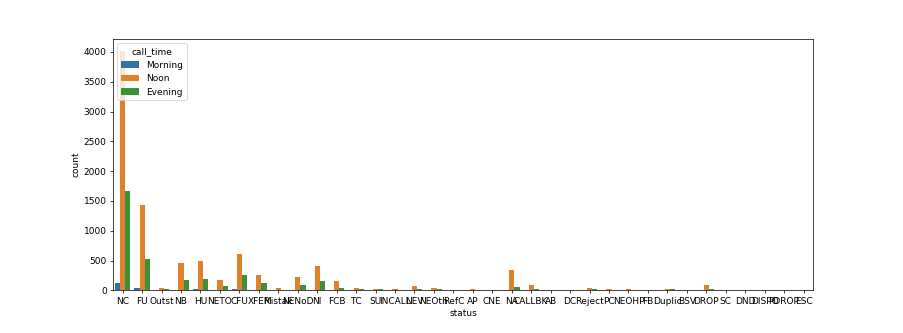

In [679]:
sns.countplot(calls_df["status"],hue=calls_df["call_time"])

### Important Observation
Approximately 4000 calls are made at Noon and 1500 calls are made at Evening in which customers are not contactable.
So there are high chances that customers might pick up the call in morning.
So if calls are made in morning,we can reduce atleast 30% of our time and calls too

# Average time spent during day,noon and Evening

In [680]:
calls_df.groupby(["call_time"])["length_in_sec"].mean()

call_time
Evening    85.206897
Morning    78.707819
Noon       84.461082
Name: length_in_sec, dtype: float64

# Average time spent on dial type

In [681]:
#More Manual Calls
calls_df.groupby(["dial_type"])["length_in_sec"].mean()

dial_type
AUTO      42.225690
MANUAL    87.424905
Name: length_in_sec, dtype: float64

# Average time spent on WeekDays

In [682]:
calls_df.pivot_table(["length_in_sec"],["call_day"],aggfunc="mean")

,length_in_sec
call_day,
Friday,81.178844
Monday,95.597930
Saturday,88.042674
Thursday,76.389722
Tuesday,83.631121
Wednesday,82.761024


Employees spend most of the time in calls on Monday

# Average time spent on each call types

In [552]:
calls_df.pivot_table(["length_in_sec"],["status"],aggfunc="mean").sort_values("length_in_sec",ascending=False)

,length_in_sec
status,
SU,467.260870
PC,433.500000
NEOHP,254.136364
TC,211.294118
BSV,207.136364
FB,183.375000
FCB,181.320197
NEOth,169.819672
RefC,159.588235


### Important Observation
For sign up call,customers are taking more time.
So we can simplify the process so that we can save customer's time

# Average time spent by each customer care employee

In [553]:
calls_df.pivot_table(["length_in_sec"],["user"],aggfunc="mean").sort_values("length_in_sec",ascending=False)

,length_in_sec
user,
reshav,199.055556
prerana,124.381916
pstdeepak,120.090909
umesh,109.290323
jyotsna,100.855882
shilpa,93.867784
PRIYANKA,93.666667
aarti,85.051440
syedriyas,84.808632


# Relation between call day and call type

In [562]:
pd.crosstab(calls_df['call_day'], calls_df['call_type'], margins=True)

call_type,Ignore,Important,Interested,Not Eligilble,Not Interested,All
call_day,,,,,,
Friday,17,479,368,1396,340,2600
Monday,33,477,373,1455,197,2535
Saturday,13,150,72,413,44,692
Thursday,8,306,240,964,233,1751
Tuesday,23,496,407,1846,218,2990
Wednesday,14,341,287,1224,133,1999
All,108,2249,1747,7298,1165,12567


Most of the InEligible calls are on Tuesday and we can see there are less number of calls on saturday and more number of calls are on Tuesday,monday and Friday

# Relation between call time and call type

In [683]:
pd.crosstab(calls_df['call_time'], calls_df['call_type'], margins=True)

call_type,Ignore,Important,Interested,Not Eligilble,Not Interested,All
call_time,,,,,,
Evening,32,610,480,2088,263,3473
Morning,3,47,28,135,21,234
Noon,73,1592,1239,5075,881,8860
All,108,2249,1747,7298,1165,12567


Most of the calls are at Noon and less calls at morning

# Relation between user and call type

In [684]:
pd.crosstab(calls_df['user'], calls_df['call_type'], margins=True)

call_type,Ignore,Important,Interested,Not Eligilble,Not Interested,All
user,,,,,,
6666,0,1,0,0,0,1
PRIYANKA,1,2,8,12,1,24
VDAD,8,0,125,155,397,685
aarti,0,196,112,569,81,958
akanksha,19,492,82,762,57,1412
anand,1,85,11,255,13,365
deepthi,6,525,18,751,91,1391
dj,0,1,0,8,1,10
jyotsna,0,293,256,932,80,1561


Most number of calls are handled by jyothsna and least calls by swati and there are 108 calls to be ignored.customers shows their uninterest in 1165 calls and most of them handled by VDAD.
Prerana has done most number of eligibility calls that is 907 calls.
Most of the Important calls are handled by deepti

# Conclusion:

Thus we have succcessfully cleaned the dataset,added new variables like call_day,call_time,month_day.
We try to understand the business value by classifying the statuses into 5 bins
we answered some basic questions and understood the relation between different variables.